In [1]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/c7/ec/9dabb6a9abfdebb3c45b0cc52dec901caafef2b2c7e7d6a839ed86d81e91/opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.6 MB 2.6 MB/s eta 0:00:16
   - -------------------------------------- 1.0/38.6 MB 13.3 MB/s eta 0:00:03
   -- ------------------------------------- 2.1/38.6 MB 16.5 MB/s eta 0:00:03
   --- ------------------------------------ 3.1/38.6 MB 17.9 MB/s eta 0:00:02
   ---- ----------------------------------- 4.1/38.6 MB 18.8 MB/s eta 0:00:02
   ----- ---------------------------------- 5.1/38.6 MB 19.0 MB/s eta 0:00:02
   ------ --------------------------------- 6.1/38.6 MB 19.5 MB/s eta 0:00:02
   ------- ---------

In [1]:
pip install torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1 --index-url https://download.pytorch.org/whl/cu121

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import  transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [16]:
import os
import cv2
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread('/'join(folder,filename))
        if img is not None:
            images.append(img)
    return images

# test와 train 폴더에서 이미지 불러오기
test_images = load_images_from_folder('./data/FER2013Test')
train_images = load_images_from_folder('./data/FER2013Train')

# 이미지 개수 출력
print(f"Test 폴더 이미지 개수: {len(test_images)}")
print(f"Train 폴더 이미지 개수: {len(train_images)}")


Test 폴더 이미지 개수: 3573
Train 폴더 이미지 개수: 28558


# Resnet50
optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [25]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Custom Dataset 클래스 정의
class CustomImageDataset(Dataset):
    def __init__(self, directory, csv_file, transform=None):
        self.directory = directory
        self.transform = transform
        self.df = pd.read_csv(csv_file)
        self.df = self.df.dropna(subset=['Image name'])
        self.df = self.df[self.df['Usage'] == ('Training' if 'Train' in directory else 'PublicTest')]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.df.iloc[idx]['Image name'])
        image = Image.open(img_name)
        label = self.df.iloc[idx][2:12].values.argmax()
        if self.transform:
            image = self.transform(image)
        return image, label

# 이미지 전처리 정의
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 이미지를 그레이스케일로 변환
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5076,], std=[0.2120]),  # 1채널 이미지에 맞게 조정
])

# 데이터셋과 데이터로더 생성 (배치 크기 감소)
train_dataset = CustomImageDataset(directory='./data/FER2013Train', csv_file='./fer2013new.csv', transform=transform)
test_dataset = CustomImageDataset(directory='./data/FER2013valid', csv_file='./fer2013new.csv', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 배치 크기 감소
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)  # 배치 크기 감소

# 모델 정의
class myResNet(nn.Module):
    def __init__(self):
        super(myResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        # 첫 번째 컨볼루션 레이어를 1채널 입력에 맞게 수정
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, x):
        return self.resnet(x)

model = myResNet().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []  # 초기화
train_accuracies = []  # 초기화
test_losses = []  # 초기화
test_accuracies = []  # 초기화

#훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item() * data.size(0)  # 배치 크기를 고려
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_loss /= total
    accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)
    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    test_loss /= total
    accuracy = 100. * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f"Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)


C:\Users\songh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\songh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 1, Training Loss: 1.9547, Accuracy: 35.43%
Test loss: 1.5665, Accuracy: 45.63%
Epoch: 2, Training Loss: 1.4384, Accuracy: 50.65%
Test loss: 1.3911, Accuracy: 53.90%
Epoch: 3, Training Loss: 1.2590, Accuracy: 56.86%
Test loss: 1.2836, Accuracy: 58.84%
Epoch: 4, Training Loss: 1.1326, Accuracy: 61.34%
Test loss: 1.1507, Accuracy: 61.64%
Epoch: 5, Training Loss: 1.0113, Accuracy: 65.26%
Test loss: 1.1507, Accuracy: 63.76%
Epoch: 6, Training Loss: 0.9008, Accuracy: 69.41%
Test loss: 1.0076, Accuracy: 65.35%
Epoch: 7, Training Loss: 0.7951, Accuracy: 73.05%
Test loss: 1.0983, Accuracy: 66.16%
Epoch: 8, Training Loss: 0.7091, Accuracy: 75.77%
Test loss: 1.1239, Accuracy: 66.61%
Epoch: 9, Training Loss: 0.6238, Accuracy: 79.08%
Test loss: 1.0783, Accuracy: 65.63%
Epoch: 10, Training Loss: 0.5395, Accuracy: 82.01%
Test loss: 1.1706, Accuracy: 65.41%


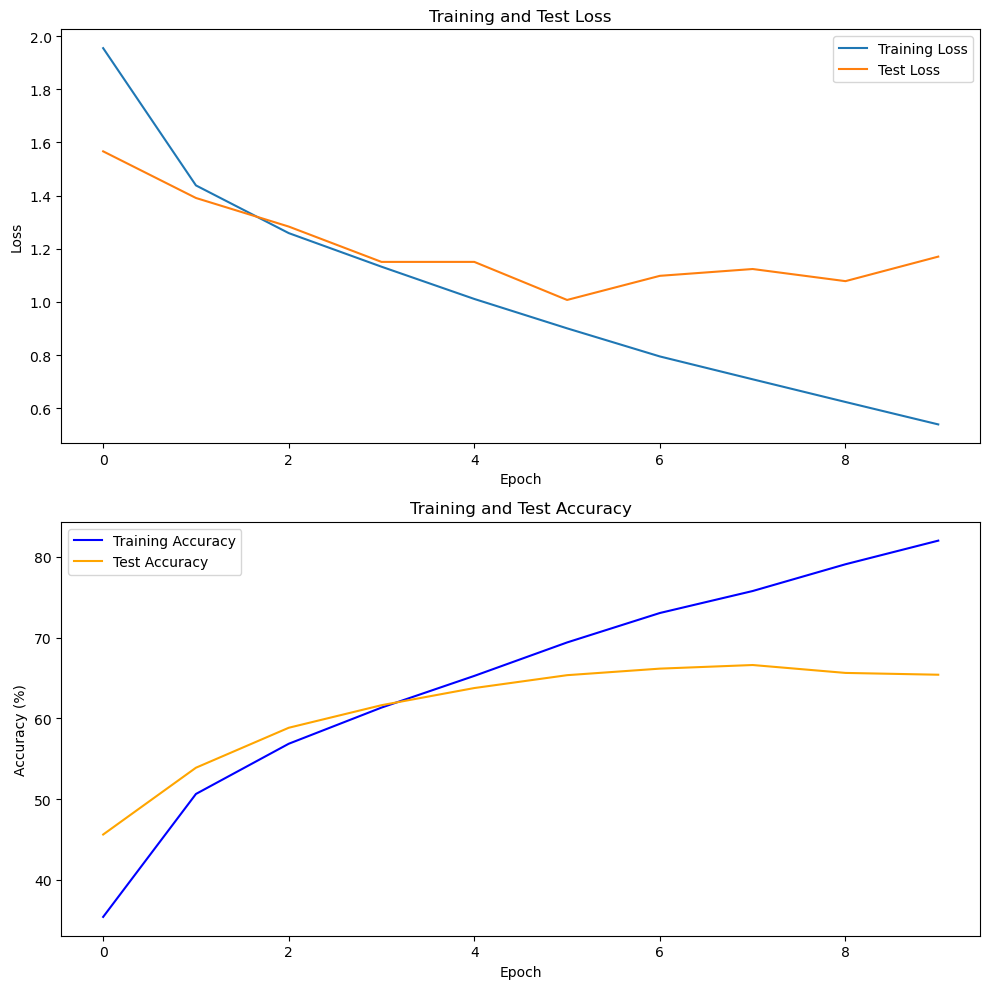

In [26]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()


In [8]:
import torch

# GPU 사용 가능 확인
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU")


GPU is available. Using GPU: NVIDIA GeForce RTX 2070 SUPER


# vgg19
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [23]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Custom Dataset 클래스 정의
class CustomImageDataset(Dataset):
    def __init__(self, directory, csv_file, transform=None):
        self.directory = directory
        self.transform = transform
        self.df = pd.read_csv(csv_file)
        self.df = self.df.dropna(subset=['Image name'])
        self.df = self.df[self.df['Usage'] == ('Training' if 'Train' in directory else 'PublicTest')]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.df.iloc[idx]['Image name'])
        image = Image.open(img_name)
        label = self.df.iloc[idx][2:12].values.argmax()
        if self.transform:
            image = self.transform(image)
        return image, label

# 이미지 전처리 정의
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 이미지를 그레이스케일로 변환
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5076,], std=[0.2120]),  # 1채널 이미지에 맞게 조정
])

# 데이터셋과 데이터로더 생성 (배치 크기 감소)
train_dataset = CustomImageDataset(directory='./data/FER2013Train', csv_file='./fer2013new.csv', transform=transform)
test_dataset = CustomImageDataset(directory='./data/FER2013valid', csv_file='./fer2013new.csv', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 배치 크기 감소
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)  # 배치 크기 감소

# 모델 정의
class myVGG19(nn.Module):
    def __init__(self):
        super(myVGG19, self).__init__()
        self.vgg19 = models.vgg19(pretrained=False)
        self.vgg19.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # 첫 번째 레이어를 1채널 입력에 맞게 수정
        num_ftrs = self.vgg19.classifier[6].in_features
        self.vgg19.classifier[6] = nn.Linear(num_ftrs, 10)  # 마지막 레이어를 10개 클래스에 맞게 조정
    
    def forward(self, x):
        return self.vgg19(x)

model = myVGG19().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []  # 초기화
train_accuracies = []  # 초기화
test_losses = []  # 초기화
test_accuracies = []  # 초기화

#훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item() * data.size(0)  # 배치 크기를 고려
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_loss /= total
    accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)
    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    test_loss /= total
    accuracy = 100. * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f"Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)


C:\Users\songh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\songh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 1, Training Loss: 1.6059, Accuracy: 37.89%
Test loss: 1.4566, Accuracy: 48.81%
Epoch: 2, Training Loss: 1.2944, Accuracy: 56.34%
Test loss: 1.1777, Accuracy: 60.60%
Epoch: 3, Training Loss: 1.0958, Accuracy: 62.98%
Test loss: 1.0604, Accuracy: 64.99%
Epoch: 4, Training Loss: 0.9489, Accuracy: 68.02%
Test loss: 0.9520, Accuracy: 67.87%
Epoch: 5, Training Loss: 0.8506, Accuracy: 71.29%
Test loss: 0.9491, Accuracy: 68.37%
Epoch: 6, Training Loss: 0.7769, Accuracy: 73.47%
Test loss: 0.8140, Accuracy: 73.09%
Epoch: 7, Training Loss: 0.7023, Accuracy: 76.25%
Test loss: 0.8806, Accuracy: 70.69%
Epoch: 8, Training Loss: 0.6324, Accuracy: 78.68%
Test loss: 0.8235, Accuracy: 74.55%
Epoch: 9, Training Loss: 0.5743, Accuracy: 80.47%
Test loss: 0.7556, Accuracy: 74.77%
Epoch: 10, Training Loss: 0.5055, Accuracy: 83.19%
Test loss: 0.8018, Accuracy: 76.25%


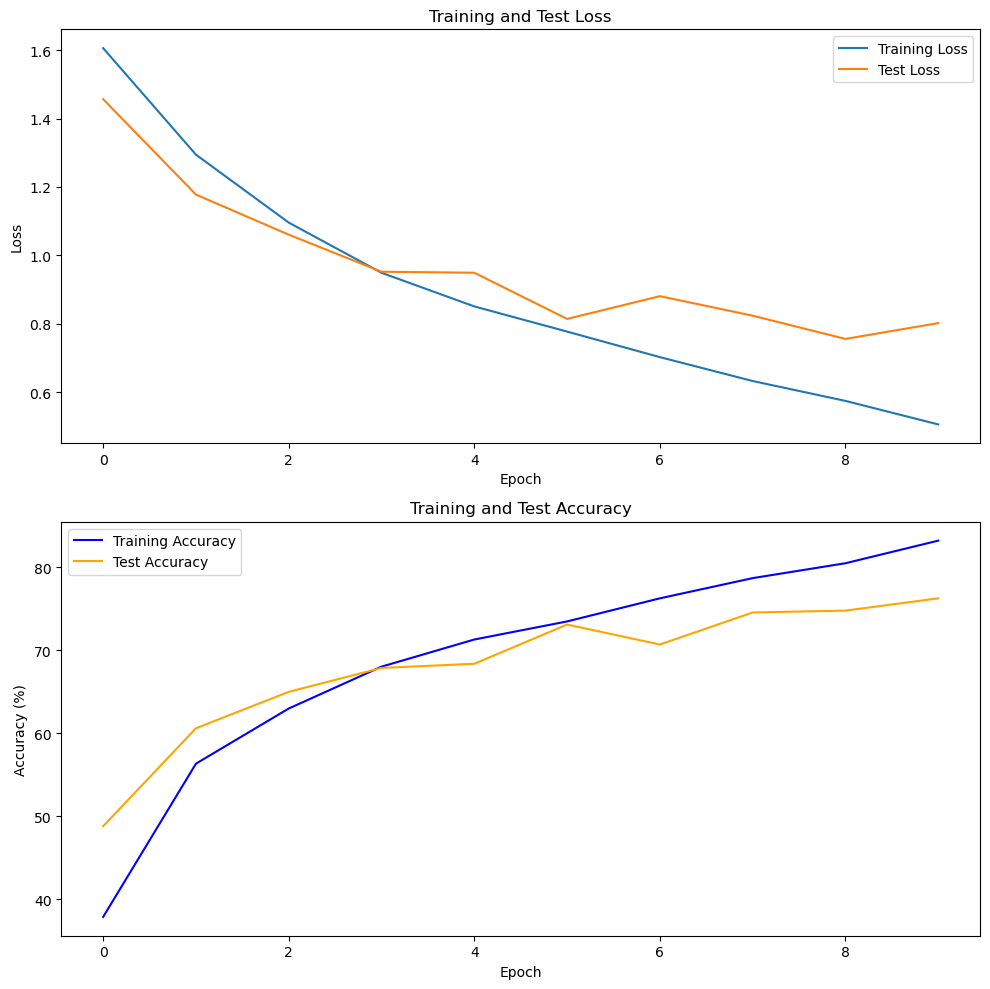

In [24]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()


# vgg19 파라미터 조절 
adam, L2 적용
optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

In [29]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Custom Dataset 클래스 정의
class CustomImageDataset(Dataset):
    def __init__(self, directory, csv_file, transform=None):
        self.directory = directory
        self.transform = transform
        self.df = pd.read_csv(csv_file)
        self.df = self.df.dropna(subset=['Image name'])
        self.df = self.df[self.df['Usage'] == ('Training' if 'Train' in directory else 'PublicTest')]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.df.iloc[idx]['Image name'])
        image = Image.open(img_name)
        label = self.df.iloc[idx][2:12].values.argmax()
        if self.transform:
            image = self.transform(image)
        return image, label

# 이미지 전처리 정의
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 이미지를 그레이스케일로 변환
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5076,], std=[0.2120]),  # 1채널 이미지에 맞게 조정
])

# 데이터셋과 데이터로더 생성 (배치 크기 감소)
train_dataset = CustomImageDataset(directory='./data/FER2013Train', csv_file='./fer2013new.csv', transform=transform)
test_dataset = CustomImageDataset(directory='./data/FER2013valid', csv_file='./fer2013new.csv', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 배치 크기 감소
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)  # 배치 크기 감소

# 모델 정의
class myVGG19(nn.Module):
    def __init__(self):
        super(myVGG19, self).__init__()
        self.vgg19 = models.vgg19(pretrained=False)
        self.vgg19.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # 첫 번째 레이어를 1채널 입력에 맞게 수정
        num_ftrs = self.vgg19.classifier[6].in_features
        self.vgg19.classifier[6] = nn.Linear(num_ftrs, 10)  # 마지막 레이어를 10개 클래스에 맞게 조정
    
    def forward(self, x):
        return self.vgg19(x)

model = myVGG19().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

train_losses = []  # 초기화
train_accuracies = []  # 초기화
test_losses = []  # 초기화
test_accuracies = []  # 초기화

#훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item() * data.size(0)  # 배치 크기를 고려
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_loss /= total
    accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)
    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    test_loss /= total
    accuracy = 100. * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f"Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)


C:\Users\songh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\songh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 1, Training Loss: 228118695781.4801, Accuracy: 33.24%
Test loss: 1.6424, Accuracy: 37.30%
Epoch: 2, Training Loss: 1.6340, Accuracy: 36.07%
Test loss: 1.6380, Accuracy: 37.30%
Epoch: 3, Training Loss: 1.6313, Accuracy: 36.06%
Test loss: 1.6556, Accuracy: 37.30%
Epoch: 4, Training Loss: 823231.5596, Accuracy: 35.86%
Test loss: 1.6377, Accuracy: 37.30%
Epoch: 5, Training Loss: 9545099226966.9805, Accuracy: 30.66%
Test loss: 1.6840, Accuracy: 37.30%
Epoch: 6, Training Loss: 5.6230, Accuracy: 34.61%
Test loss: 1.6454, Accuracy: 37.30%
Epoch: 7, Training Loss: 3.0226, Accuracy: 35.24%
Test loss: 1.6402, Accuracy: 37.30%
Epoch: 8, Training Loss: 2.6583, Accuracy: 35.17%
Test loss: 1.6400, Accuracy: 37.30%
Epoch: 9, Training Loss: 5106367351622.7031, Accuracy: 33.44%
Test loss: 1.6404, Accuracy: 37.30%
Epoch: 10, Training Loss: 55.3723, Accuracy: 35.94%
Test loss: 1.6418, Accuracy: 37.30%


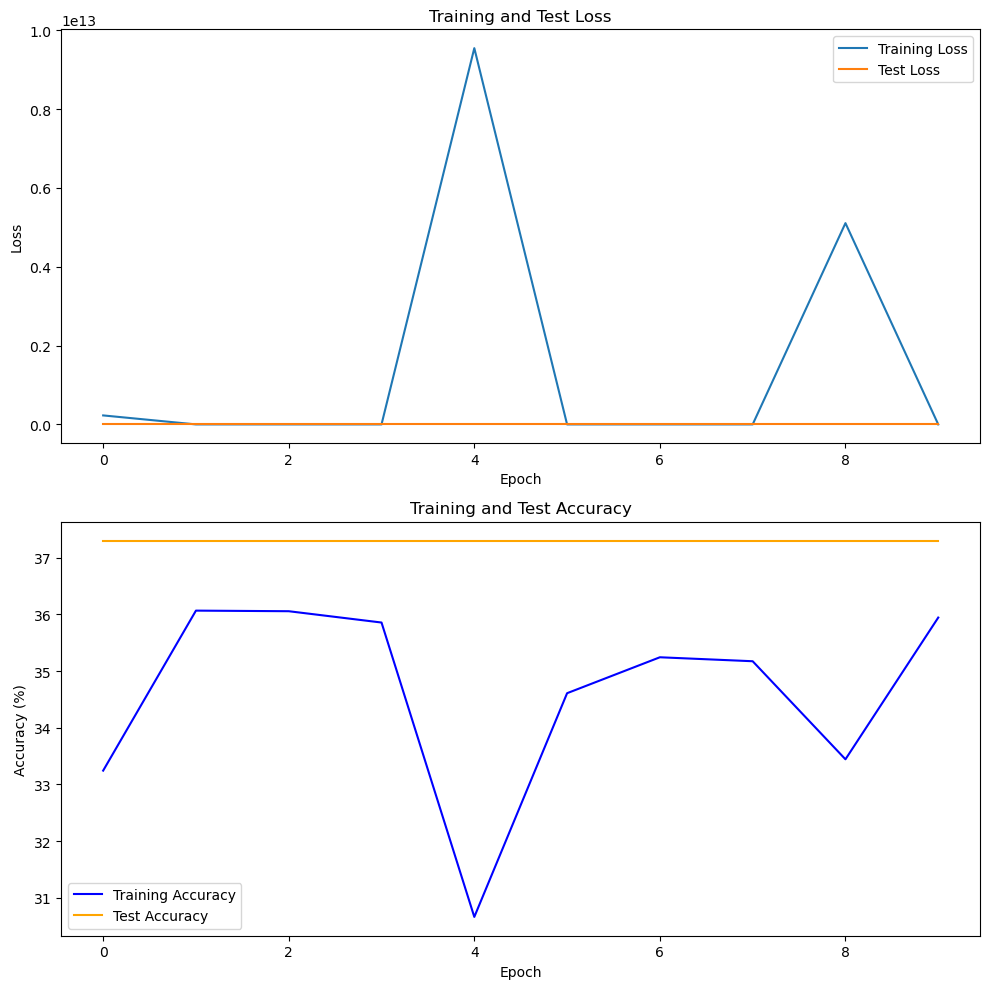

In [30]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()


# vgg19 파라미터 조절 
 optim.Adam(model.parameters(), lr=0.01)

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Custom Dataset 클래스 정의
class CustomImageDataset(Dataset):
    def __init__(self, directory, csv_file, transform=None):
        self.directory = directory
        self.transform = transform
        self.df = pd.read_csv(csv_file)
        self.df = self.df.dropna(subset=['Image name'])
        self.df = self.df[self.df['Usage'] == ('Training' if 'Train' in directory else 'PublicTest')]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.df.iloc[idx]['Image name'])
        image = Image.open(img_name)
        label = self.df.iloc[idx][2:12].values.argmax()
        if self.transform:
            image = self.transform(image)
        return image, label

# 이미지 전처리 정의
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 이미지를 그레이스케일로 변환
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5076,], std=[0.2120]),  # 1채널 이미지에 맞게 조정
])

# 데이터셋과 데이터로더 생성 (배치 크기 감소)
train_dataset = CustomImageDataset(directory='./data/FER2013Train', csv_file='./fer2013new.csv', transform=transform)
test_dataset = CustomImageDataset(directory='./data/FER2013valid', csv_file='./fer2013new.csv', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 배치 크기 감소
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)  # 배치 크기 감소

# 모델 정의
class myVGG19(nn.Module):
    def __init__(self):
        super(myVGG19, self).__init__()
        self.vgg19 = models.vgg19(pretrained=False)
        self.vgg19.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # 첫 번째 레이어를 1채널 입력에 맞게 수정
        num_ftrs = self.vgg19.classifier[6].in_features
        self.vgg19.classifier[6] = nn.Linear(num_ftrs, 10)  # 마지막 레이어를 10개 클래스에 맞게 조정
    
    def forward(self, x):
        return self.vgg19(x)

model = myVGG19().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses = []  # 초기화
train_accuracies = []  # 초기화
test_losses = []  # 초기화
test_accuracies = []  # 초기화

#훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item() * data.size(0)  # 배치 크기를 고려
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_loss /= total
    accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)
    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    test_loss /= total
    accuracy = 100. * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f"Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)


C:\Users\songh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\songh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 1, Training Loss: 178297939440.2137, Accuracy: 34.74%
Test loss: 1.6399, Accuracy: 37.30%
Epoch: 2, Training Loss: 155.1656, Accuracy: 36.09%
Test loss: 1.6388, Accuracy: 37.30%
Epoch: 3, Training Loss: 16.3451, Accuracy: 36.09%
Test loss: 1.6376, Accuracy: 37.30%
Epoch: 4, Training Loss: 7.8657, Accuracy: 36.09%
Test loss: 1.6384, Accuracy: 37.30%
Epoch: 5, Training Loss: 1.6299, Accuracy: 36.10%
Test loss: 1.6412, Accuracy: 37.30%
Epoch: 6, Training Loss: 6.4813, Accuracy: 36.08%
Test loss: 1.6387, Accuracy: 37.30%
Epoch: 7, Training Loss: 1.6301, Accuracy: 36.09%
Test loss: 1.6384, Accuracy: 37.30%
Epoch: 8, Training Loss: 1.6301, Accuracy: 36.09%
Test loss: 1.6385, Accuracy: 37.30%
Epoch: 9, Training Loss: 1.6304, Accuracy: 36.09%
Test loss: 1.6388, Accuracy: 37.30%
Epoch: 10, Training Loss: 11.1923, Accuracy: 36.09%
Test loss: 1.6390, Accuracy: 37.30%


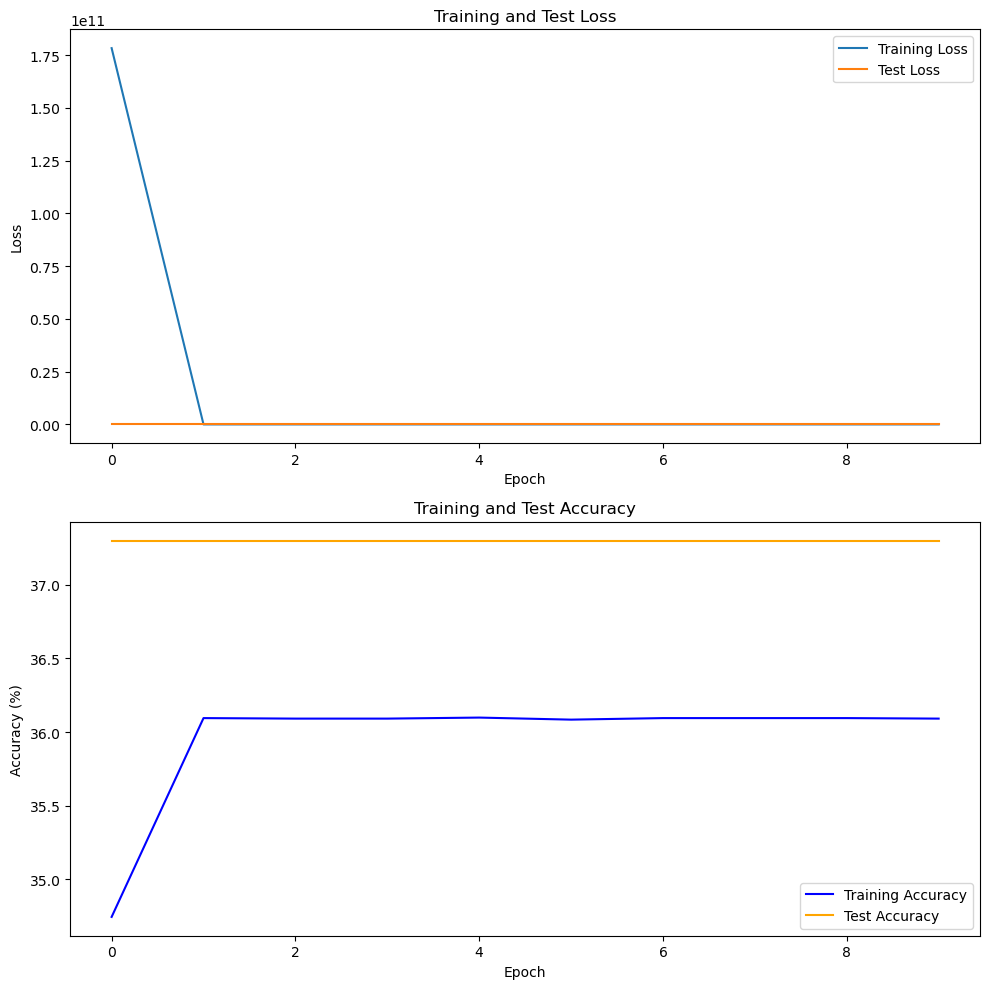

In [2]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()
